```
Coursework Assignment: Building a Regression Model
University of London
BSc in Computer Science
CM3005, Data Science
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```


# I. Introduction


## Domain-specific area


## Dataset


## Objectives


# II. Implementation


## Preprocessing


In [1]:
import pathlib

data_folderpath = pathlib.Path("./data")

ppd_folderpath = data_folderpath / "uk-ppd"
inflation_filepath = data_folderpath / "uk-ons/ons-inflation-1989-2022.csv"
interest_filepath = data_folderpath / "uk-boe/boe-interest-1975-2022.csv"


In [2]:
import pandas as pd

pd.set_option('display.float_format', lambda x: "{:,.3f}".format(x))


In [3]:
# https://www.gov.uk/guidance/about-the-price-paid-data
ppd_property_type = {
    "D": "detached",
    "S": "semi-detached",
    "T": "terraced",
    "F": "flat/maisonettes",
    #"O": "other" # => intentionally ommitted
}

ppd_duration = {
    "F": "freehold",
    "L": "leasehold"
}

ppd_old_or_new = {
    "Y": "new",
    "N": "old"
}

ppd_df = pd.concat(
    [
        pd.read_csv(
            ppd_filepath,
            #nrows=100,
            compression="zip",
            names=[
                "id",
                "price",
                "date",
                "postcode",
                "property_type",
                "old_or_new",
                "duration",
                "paon",
                "saon",
                "street",
                "locality",
                "town_city",
                "district",
                "county",
                "ppd_category_type",
                "record_status",
            ],
        )
        for ppd_filepath in ppd_folderpath.glob("*.zip")
    ]
)
ppd_df["postgroup"] = ppd_df["postcode"].map(lambda x: str(x).split(" ")[0])
ppd_df["date"] = pd.to_datetime(ppd_df["date"])
ppd_df["property_type"] = ppd_df["property_type"].map(ppd_property_type.get)
ppd_df["duration"] = ppd_df["duration"].map(ppd_duration.get)
ppd_df["old_or_new"] = ppd_df["old_or_new"].map(ppd_old_or_new.get)
ppd_df = ppd_df[
    [
        "date",
        "postgroup",
        "property_type",
        "old_or_new",
        "duration",
        "price",
    ]
]
ppd_df = ppd_df.astype(
    {
        "postgroup": "category",
        "property_type": "category",
        "old_or_new": "category",
        "duration": "category",
        "price": "double",
    }
)
ppd_df = ppd_df.dropna()
ppd_df.sample(n=5)


,date,postgroup,property_type,old_or_new,duration,price
523186,2019-12-23,CH4,terraced,old,freehold,"200,000.000"
1096972,2021-09-24,TA21,detached,old,freehold,"750,000.000"
851905,2021-06-28,ME10,semi-detached,old,freehold,"316,500.000"
33138,2021-08-04,TF9,detached,old,freehold,"320,000.000"
193485,2021-11-10,YO8,terraced,old,freehold,"166,000.000"


In [4]:
import re
import string
from datetime import date

inflation_date_pattern = re.compile(r"([\d]{4})(?:\s+([\w]{3}))?")
inflation_month_names = [
    "JAN",
    "FEB",
    "MAR",
    "APR",
    "MAY",
    "JUN",
    "JUL",
    "AUG",
    "SEP",
    "OCT",
    "NOV",
    "DEC",
]
inflation_month_index = {mn: ix + 1 for (ix, mn) in enumerate(inflation_month_names)}
inflation_month_index["Q1"] = 1
inflation_month_index["Q2"] = 4
inflation_month_index["Q3"] = 7
inflation_month_index["Q3"] = 10

inflation_acceptable_numeric_chars = string.digits + ".,"


def extract_inflation_date(x: str) -> date:
    match = next(inflation_date_pattern.finditer(x), None)
    if match:
        group_count = len(match.groups())
        if group_count >= 1:
            year = int(match.group(1))
            month = 1
            month_name = match.group(2)
            if group_count > 1 and month_name:
                month_name = month_name.strip().upper()
                month = inflation_month_index.get(month_name)
            return date(year, month, 1)


def extract_inflation_rate(x: str) -> float:
    x = str(x)
    if all([c in inflation_acceptable_numeric_chars for c in x]):
        return float(x)
    return None


inflation_df = pd.read_csv(inflation_filepath)
inflation_df["date"] = inflation_df["Title"].map(extract_inflation_date)
inflation_df["date"] = pd.to_datetime(inflation_df["date"])
inflation_df["rate"] = inflation_df["CPIH ANNUAL RATE 00: ALL ITEMS 2015=100"].map(
    extract_inflation_rate
)
inflation_df["rate"] = inflation_df["rate"].astype("float", errors="ignore")
inflation_df = inflation_df[["date", "rate"]]
inflation_df = inflation_df.dropna()
inflation_df = inflation_df.set_index("date").sort_index()
inflation_df.sample(n=5)


,rate
date,
1993-01-01,2.500
2019-04-01,2.000
1996-01-01,2.800
2014-01-01,1.800
2014-05-01,1.500


In [5]:
interest_df = pd.read_csv(interest_filepath)
interest_df["date"] = pd.to_datetime(interest_df["Date Changed"])
interest_df["rate"] = interest_df["Rate"].astype("float")
interest_df = interest_df[["date", "rate"]]
interest_df = interest_df.set_index("date").sort_index()
interest_df.sample(n=5)


,rate
date,
1978-05-08,8.750
1994-02-08,5.130
1998-10-08,7.250
1988-08-08,10.880
1981-12-04,14.380


In [6]:
from tqdm import tqdm, trange
from typing import Callable
from datetime import date, timedelta

tqdm.pandas()


def build_rate_extractor(df: pd.DataFrame) -> Callable[[date], float]:
    min_date = df.index.min()
    max_date = df.index.max()
    cur_date = min_date
    rate_index = {}
    first_rate = df.rate[0]
    prev_rate = first_rate
    last_rate = df.rate[-1]
    with trange((max_date - min_date).days, desc="rate_index") as pbar:
        while cur_date <= max_date:
            rates = df[df.index == cur_date].rate
            if rates.any():
                new_rate = rates[0] / 100.
                rate_index[cur_date] = new_rate
                prev_rate =  new_rate
            else:
                rate_index[cur_date] = prev_rate
            cur_date += timedelta(days=1)
            pbar.update()
    def get_rate_for_date(d: date) -> float:
        if d < min_date:
            return first_rate
        elif d > max_date:
            return last_rate
        else:
            return rate_index[d]
    return  get_rate_for_date


df = ppd_df.copy()
df["inflation_rate"] = df.date.progress_map(build_rate_extractor(df=inflation_df))
df["interest_rate"] = df.date.progress_map(build_rate_extractor(df=interest_df))
df.sample(n=5)


rate_index: 12358it [00:06, 1770.94it/s]                           
100%|██████████| 4336841/4336841 [00:17<00:00, 240960.63it/s]
rate_index: 17497it [00:06, 2502.72it/s]                           
100%|██████████| 4336841/4336841 [00:15<00:00, 285784.02it/s]


,date,postgroup,property_type,old_or_new,duration,price,inflation_rate,interest_rate
606149,2019-01-31,WD19,flat/maisonettes,old,leasehold,"240,000.000",0.018,0.007
399106,2019-07-26,BA1,flat/maisonettes,old,leasehold,"290,022.000",0.020,0.007
44482,2019-06-03,DN22,detached,old,freehold,"165,000.000",0.019,0.007
685227,2019-10-11,NN14,terraced,old,freehold,"157,000.000",0.015,0.007
558454,2020-04-01,CB8,detached,old,freehold,"220,000.000",0.009,0.001


## Statistical Summary


## Data visualisation


In [7]:
%matplotlib inline

In [8]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

In [9]:
max_price = float(df.price.max())
max_rate = max(df.interest_rate.max(), df.inflation_rate.max())
min_intersecting_date = df.date.min()
max_intersecting_date = df.date.max()


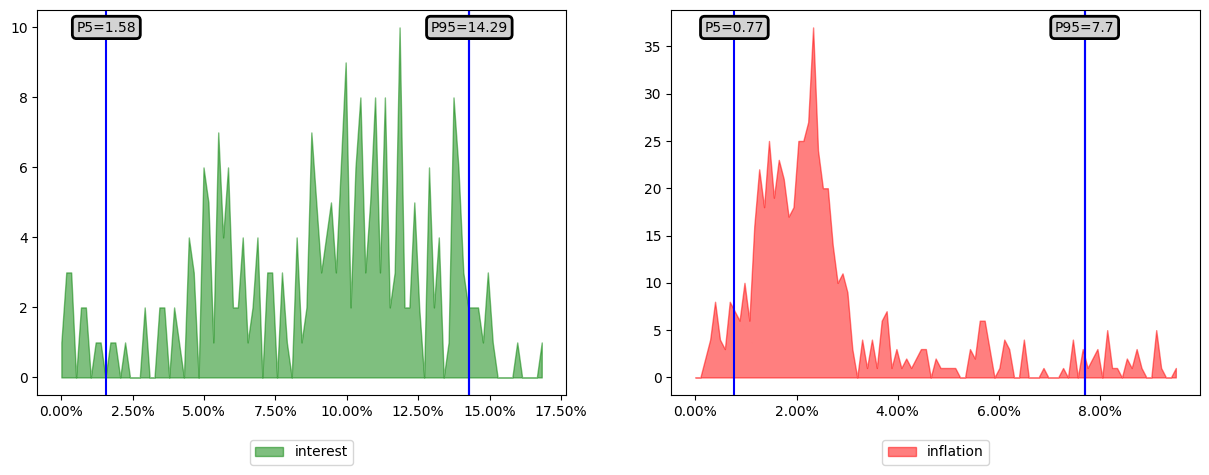

In [10]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

def plot_rate_distributions(ax, df: pd.DataFrame, label: str, color: str):
    df = df.copy()
    x = np.linspace(0.0, df["rate"].max(), 100)
    df["bin"] = pd.cut(df["rate"], bins=x)
    y = list(df.groupby("bin").count()["rate"])
    ax.fill_between(x[:-1], 0.0, y, color=color, alpha=0.5)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
    intervals = [0.05, 0.95]
    for interval, quantile in zip(intervals, df.rate.quantile(intervals)):
        percentile = f"P{int(interval*100.)}={round(quantile, 2)}"
        bbox = dict(boxstyle="round, pad=0.3", fc="lightgray", lw=2)
        ax.axvline(x=quantile, color="blue")
        ax.annotate(
            percentile,
            xy=(quantile, max(y)),
            bbox=bbox,
            ha="center",
            va="center",
        )
    ax.axvline(x=quantile, color="blue")
    ax.legend([label], loc="lower center", bbox_to_anchor=(0.5, -0.2))

plot_rate_distributions(
    ax=axes[0],
    df=interest_df,
    label="interest",
    color="green",
)

plot_rate_distributions(
    ax=axes[1],
    df=inflation_df,
    label="inflation",
    color="red",
)


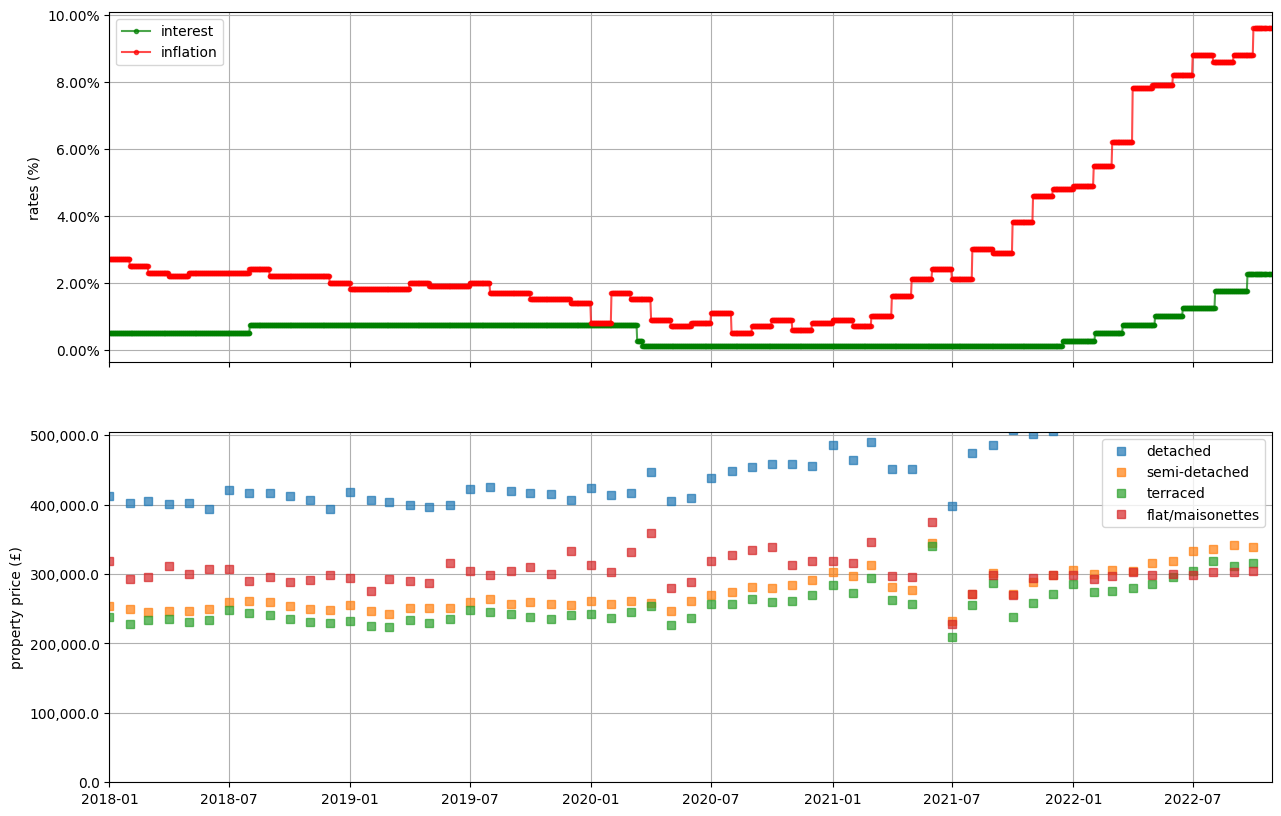

In [11]:
from datetime import date

_, axes = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

series = df.groupby("date").mean(numeric_only=True).dropna()

x = series.index

axes[0].grid(visible=True)
axes[0].plot(x, series.interest_rate * 100., "g.-", alpha=0.7)
axes[0].plot(x, series.inflation_rate * 100., "r.-", alpha=0.7)
axes[0].set_xlim(left=min_intersecting_date, right=max_intersecting_date)
axes[0].set_ylabel("rates (%)")
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
axes[0].legend(["interest", "inflation"])

axes[1].grid(visible=True)
axes[1].yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
axes[1].set_ylim(0., df.price.quantile(0.8) * 1.2)
axes[1].set_ylabel("property price (£)")
for ix, property_type in enumerate(ppd_property_type.values()):
    sub_series = df[df.property_type == property_type].copy()
    sub_series["year"] = sub_series['date'].map(lambda x: date(x.year, x.month, 1))
    sub_series = sub_series[["year", "price"]]
    sub_series = sub_series.groupby("year").mean(numeric_only=True)
    sub_series = sub_series.fillna(method='ffill')
    axes[1].plot(sub_series.index, sub_series.price, "s", alpha=0.7)
axes[1].legend(ppd_property_type.values())

## Machine learning model


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [12]:
model = make_pipeline(
    DictVectorizer(sparse=True),
    PolynomialFeatures(degree=3),
    LinearRegression(),
)

In [ ]:
# TODO: continue

# III. Conclusions


## Performance of results


## Closing remarks/statements
